In [9]:
# run multi-walker

sbatch_base = '''#!/bin/bash

#SBATCH --mail-type=ALL
#SBATCH --mail-user=mikejones@uchicago.ed

#SBATCH --partition=gpu #andrewferguson-gpu
#SBATCH --account=pi-andrewferguson
#SBATCH --nodes=1 # SET NUM NODES
#SBATCH --ntasks-per-node=1  # SETS NUM MPI RANKS (1 PER GPU)
##SBATCH --cpus-per-task=8  # SET NUM THREADS (cores)
#SBATCH --mem=20GB # REQUEST MEMORY
#SBATCH --gres=gpu:1 # SET NUM GPUS *
#SBATCH --exclude=midway3-0294

#SBATCH --job-name=diffusion
#SBATCH --output=job.out

NTASKS=$(($SLURM_NTASKS_PER_NODE * $SLURM_JOB_NUM_NODES))
OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

module load openmpi
module load python
module load cuda

'''

#run_line = 'python run_training_MJ.py --model Unet_cond --save cond --nsteps 500000 --train train_pep --cond test_pep_cond --natoms 20 --nsrvs 4'
#run_line = 'python run_training_MJ.py --model Unet_xyz --save xyz_10k --nsteps 10000 --train train_pep --cond test_pep_cond --natoms 20 --nsrvs 4'

loss = 'l1'
beta = 'cosine'
model = 'Unet1D'
n_steps = 500000

train_file = 'train_adp'
cond_file = 'test_adp_cond'
n_atoms = 8
n_srvs = 2

#for hyper in ['urandom', 'uself', 'usinu']:

save = f'adp_{model}_{n_steps}s'

run_line = f'python run_training_MJ.py --model {model} --save {save} --beta {beta} --loss {loss} --nsteps {n_steps} --train {train_file} --cond {cond_file} --natoms {n_atoms} --nsrvs {n_srvs}'
sbatch_txt = sbatch_base + run_line

with open(f'./job.sbatch', 'w') as f:
    f.write(sbatch_txt)
f.close()

!sbatch job.sbatch

sbatch: Verify job submission ...
sbatch: Using a shared partition ...
sbatch: Partition: gpu
sbatch: QOS-Flag: gpu
sbatch: Account: pi-andrewferguson
sbatch: Verification: ***PASSED***
Submitted batch job 360417


In [74]:
# reload model for inference only

sbatch_base = '''#!/bin/bash

#SBATCH --mail-type=ALL
#SBATCH --mail-user=mikejones@uchicago.ed

#SBATCH --partition=gpu #andrewferguson-gpu
#SBATCH --account=pi-andrewferguson
#SBATCH --nodes=1 # SET NUM NODES
#SBATCH --ntasks-per-node=1  # SETS NUM MPI RANKS (1 PER GPU)
##SBATCH --cpus-per-task=8  # SET NUM THREADS (cores)
#SBATCH --mem=20GB # REQUEST MEMORY
#SBATCH --gres=gpu:1 # SET NUM GPUS *
#SBATCH --exclude=midway3-0294

#SBATCH --job-name=diffusion
#SBATCH --output=job_reload.out

NTASKS=$(($SLURM_NTASKS_PER_NODE * $SLURM_JOB_NUM_NODES))
OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

module load openmpi
module load python
module load cuda

'''

loss = 'l1'
beta = 'cosine'
nsteps = 100 #1000000
model = 'Unet1D'

#for hyper in ['urandom', 'uself', 'usinu']:

for n_steps in [1000000, 2000000]:

    save = f'AA-heavy_{model}_{n_steps}s'

    run_line = f'python run_reload_MJ.py --model {model} --save {save} --beta {beta} --loss {loss} --nsteps {n_steps} --train train_pep_AA-heavy --cond test_pep_AA-heavy_cond --natoms 94 --nsrvs 4'
    print(run_line)
    
    sbatch_txt = sbatch_base + run_line

    with open(f'./job.sbatch', 'w') as f:
        f.write(sbatch_txt)
    f.close()

    !sbatch job.sbatch

python run_reload_MJ.py --model Unet1D --save AA-heavy_Unet1D_1000000s --beta cosine --loss l1 --nsteps 1000000 --train train_pep_AA-heavy --cond test_pep_AA-heavy_cond --natoms 94 --nsrvs 4
sbatch: Verify job submission ...
sbatch: Using a shared partition ...
sbatch: Partition: gpu
sbatch: QOS-Flag: gpu
sbatch: Account: pi-andrewferguson
sbatch: Verification: ***PASSED***
Submitted batch job 345733
python run_reload_MJ.py --model Unet1D --save AA-heavy_Unet1D_2000000s --beta cosine --loss l1 --nsteps 2000000 --train train_pep_AA-heavy --cond test_pep_AA-heavy_cond --natoms 94 --nsrvs 4
sbatch: Verify job submission ...
sbatch: Using a shared partition ...
sbatch: Partition: gpu
sbatch: QOS-Flag: gpu
sbatch: Account: pi-andrewferguson
sbatch: Verification: ***PASSED***
Submitted batch job 345734


### Hyper param notes
- L1 loss is much better
- Flattened is a bit better than xyz but conditions worse
- cosine noise a bit better 
- Unet1D is a bit better but substantially slower 
- Adding any True makes things worse

### To try:
- Expanding architecture
- Conditioning on all heavy tics

In [15]:
!squeue -u mikejones

print('\n')
!squeue -p andrewferguson-gpu

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            360417       gpu diffusio mikejone  R       7:31      1 midway3-0286
            360310       gpu diffusio mikejone  R      40:46      1 midway3-0286
            359035       gpu _interac mikejone  R    1:14:23      1 midway3-0286


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            352945 andrewfer gen=256_  kirills  R    5:18:24      1 midway3-0305
            351447 andrewfer gen=256_  kirills  R   17:34:02      1 midway3-0305
            351448 andrewfer gen=512_  kirills  R   17:34:02      1 midway3-0305
            351449 andrewfer gen=1024  kirills  R   17:34:02      1 midway3-0305


In [13]:
!scancel  345649 345648
#!sacct --format=User,JobID,Jobname,partition,state,time,start,end

In [9]:
# reload test to check results

import numpy as np
import mdshare 
import mdtraj as md
import glob
import pyemma as py
import matplotlib.pyplot as plt

n_srvs = 4
AA_features = True
samples_name = 'AA_1000k'

if AA_features:
    n_atoms = 94
    train_name = 'train_pep_AA'
    test_name = 'test_pep_AA'

else:
    n_atoms = 20
    train_name = 'train_pep'
    test_name = 'test_pep'
    
# load test samples
test_r = np.load(f'./traj_AIB9/{test_name}_traj.npy')
test_r = test_r[:, n_srvs:].reshape((-1, n_atoms, 3))

# load synthetics
test_s = np.load(f'./results/{train_name}/32-1-2-2-4-b128/given_3_op/samples_{samples_name}.npy')
test_s = np.squeeze(test_s)[:, n_srvs:].reshape((-1, n_atoms, 3))

# load in original training
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data_mdshare')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data_mdshare')
glob_files = glob.glob('./data_mdshare/pentapeptide-*-500ns-impl-solv.xtc')

trj = md.load(files, top=pdb)
trjs = [md.load(file, top=pdb) for file in glob_files]

# load both in trajs
heavy_idxs = trj.top.select('backbone')
heavy_trj = trj.atom_slice(heavy_idxs)
heavy_trj = heavy_trj.superpose(heavy_trj)
heavy_trjs = [t.atom_slice(heavy_idxs) for t in trjs]

# load using heavy trj top
if AA_features:
    trj_full_r = md.Trajectory(test_r, topology=trj.top)
    trj_full_s = md.Trajectory(test_s, topology=trj.top)
    
    trj_r = trj_full_r.atom_slice(heavy_idxs)
    trj_s = trj_full_s.atom_slice(heavy_idxs)

else:
    trj_r = md.Trajectory(test_r, topology=heavy_trj.top)
    trj_s = md.Trajectory(test_s, topology=heavy_trj.top)

print(trj_r.xyz.shape, trj_s.xyz.shape)

(25025, 20, 3) (25025, 20, 3)


(25, 5001, 190)


calculate covariances:   0%|          | 0/25 [00:00<?, ?it/s]

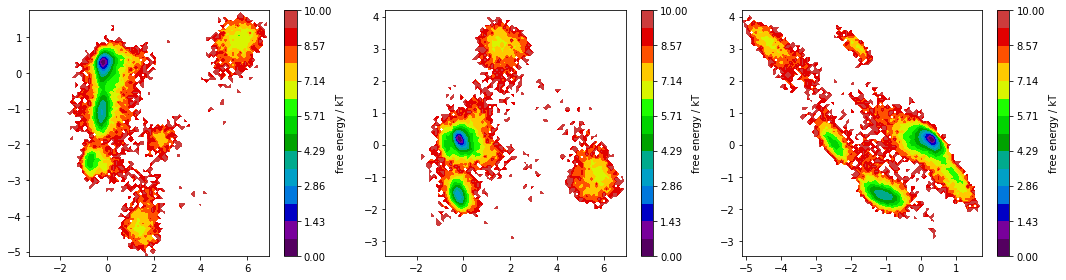

In [10]:
# train tica using pyemma
from pyemma.coordinates import tica
from scipy.spatial.distance import pdist

# train tica
pdists = [np.concatenate([pdist(xyz)[None] for xyz in trj.xyz]) for trj in heavy_trjs]

print(np.shape(pdists))

TICA = tica(pdists, lag=5, dim=4)

projected_data = np.array(TICA.transform(pdists))
projected_data_cat = projected_data.reshape(-1, projected_data.shape[-1])
projected_data_cat.shape

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,1], levels=np.linspace(0, 10, 15), ax=ax[0])
py.plots.plot_free_energy(projected_data_cat[:,0], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[1])
py.plots.plot_free_energy(projected_data_cat[:,1], projected_data_cat[:,2], levels=np.linspace(0, 10, 15), ax=ax[2])
plt.tight_layout()

In [11]:
# plot collective variables

phi_r = md.compute_phi(trj_r)[1]
phi_s = md.compute_phi(trj_s)[1]

tics_r = TICA.transform(np.array([pdist(xyz) for xyz in trj_r.xyz]))
tics_s = TICA.transform(np.array([pdist(xyz) for xyz in trj_s.xyz]))

print (phi_r.shape, phi_s.shape)
print (tics_r.shape, tics_s.shape)

(25025, 4) (25025, 4)
(25025, 4) (25025, 4)


Pearson Phi:   0.9304
Pearson Psi:   0.9583
ks/pval Phi:   0.0151 0.0066
ks/pval Psi:   0.0431 0.0


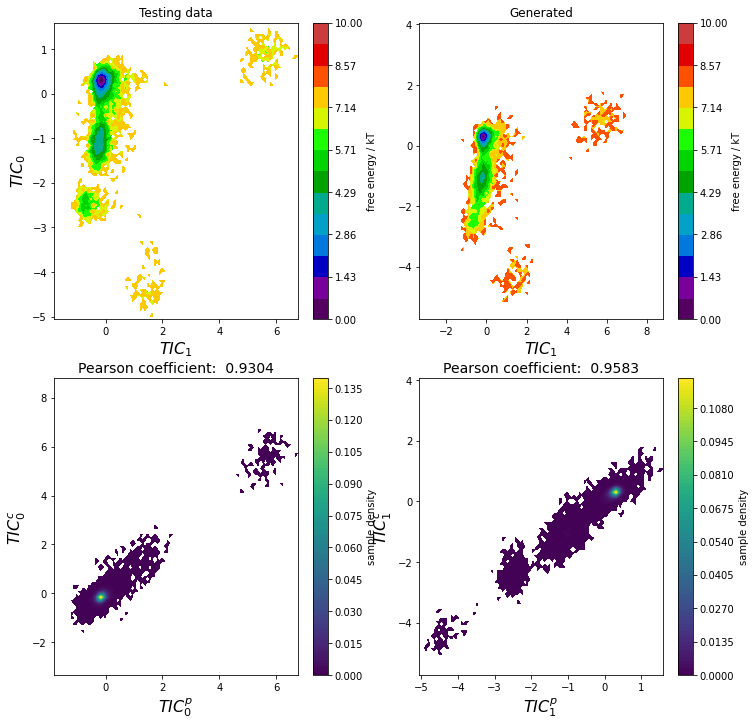

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

fig, axes = plt.subplots(2, 2, figsize=(12, 12)) #, sharex=True, sharey=True)

# real and synthetic coords
r, s = tics_r, tics_s #phi_r, phi_s

# x and y indices
x_idx, y_idx = 0, 1

xy = np.array([x_idx, y_idx])

py.plots.plot_free_energy(*r[:, xy].T, ax=axes[0, 0], levels=np.linspace(0, 10, 15))
py.plots.plot_free_energy(*s[:, xy].T, ax=axes[0, 1], levels=np.linspace(0, 10, 15))

axes[0, 0].set_title('Testing data')
axes[0, 1].set_title('Generated')

axes[0, 0].set_ylabel(rf'$TIC_{x_idx}$', fontsize=16)
axes[0, 0].set_xlabel(rf'$TIC_{y_idx}$', fontsize=16)
axes[0, 1].set_xlabel(rf'$TIC_{y_idx}$', fontsize=16)

# based on what it should be conditioned on:
py.plots.plot_density(r[:, 0], s[:, 0], ax=axes[1, 0])
py.plots.plot_density(r[:, 1], s[:, 1], ax=axes[1, 1])

axes[1, 0].set_xlabel(rf'$TIC_{x_idx}^p$', fontsize=16)
axes[1, 0].set_ylabel(rf'$TIC_{x_idx}^c$', fontsize=16)

axes[1, 1].set_xlabel(rf'$TIC_{y_idx}^p$', fontsize=16)
axes[1, 1].set_ylabel(rf'$TIC_{y_idx}^c$', fontsize=16)

# print correlation between condtions
p_phi, _ = pearsonr(r[:, x_idx], s[:, x_idx])
p_psi, _ = pearsonr(r[:, y_idx], s[:, y_idx])

ks_phi = ks_2samp(r[:, x_idx], s[:, x_idx])
ks_psi = ks_2samp(r[:, y_idx], s[:, y_idx])

axes[1, 0].set_title('Pearson coefficient:  ' + str(np.round(p_phi, 4)), fontsize=14)
axes[1, 1].set_title('Pearson coefficient:  ' + str(np.round(p_psi, 4)), fontsize=14)

print('Pearson Phi:  ', np.round(p_phi, 4))
print('Pearson Psi:  ', np.round(p_psi, 4))
print('ks/pval Phi:  ', np.round(ks_phi.statistic, 4), np.round(ks_phi.pvalue, 4))
print('ks/pval Psi:  ', np.round(ks_psi.statistic, 4), np.round(ks_psi.pvalue, 4))


In [13]:
# compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
view.add_trajectory(trj_r)
view.add_trajectory(trj_s)

op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25024)

In [14]:
# compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
#view.add_trajectory(trj_full_r)
view.add_trajectory(trj_full_s)

op_list = [1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25024)

In [29]:
# generate multiple configurations form the

In [30]:
# compare reconstructed traj against conditioning

from nglview import NGLWidget

view = NGLWidget() 
#view.add_trajectory(trj_full_r)
view.add_trajectory(trj_full_s)

op_list = [1.0] #[0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=25024)